## Importing packages

In [1]:
import prepare
import acquire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error
from math import sqrt 

## Acquiring data

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByState.csv')

## Prep

In [3]:
# Specifies the state of New Mexico, sets date as index, resamples by year, and takes only the dates past 1900 
# to avoid high uncertainty

df = df[df['State'] == 'New Mexico']
df['dt'] = pd.to_datetime(df.dt)
df = df.set_index('dt')
df = df.resample('Y').mean()
df = df.loc['1900-01-01':]

In [4]:
df

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1900-12-31,12.172417,0.433083
1901-12-31,12.051583,0.447167
1902-12-31,11.963167,0.466833
1903-12-31,11.166833,0.509250
1904-12-31,11.833250,0.478583
...,...,...
2009-12-31,12.502667,0.182167
2010-12-31,12.452250,0.169583
2011-12-31,12.734000,0.189250


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 1900-12-31 to 2013-12-31
Freq: A-DEC
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             114 non-null    float64
 1   AverageTemperatureUncertainty  114 non-null    float64
dtypes: float64(2)
memory usage: 2.7 KB


## Split

In [6]:
# set train size to be 50% of total 
train_size = int(len(df) * .5)
train_size

# set validate size to be 30% of total 
validate_size = int(len(df) * .3)
validate_size

# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

validate_end_index = train_size + validate_size

In [7]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

## Explore

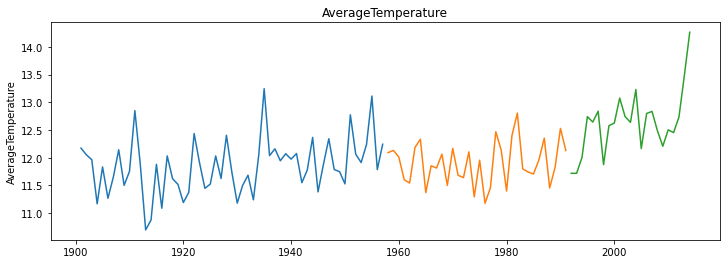

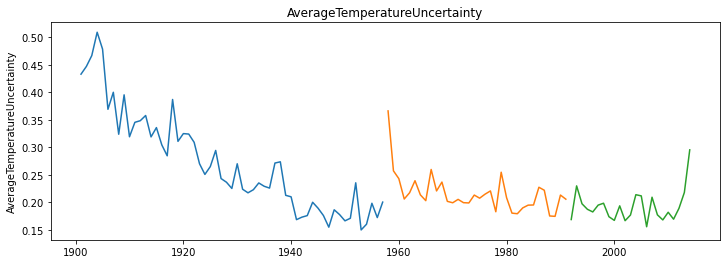

In [8]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

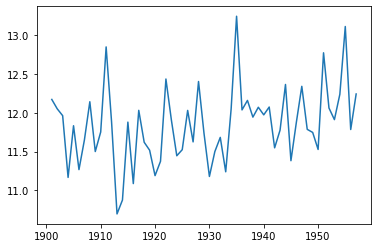

In [9]:
plt.plot(train.index, train.AverageTemperature)

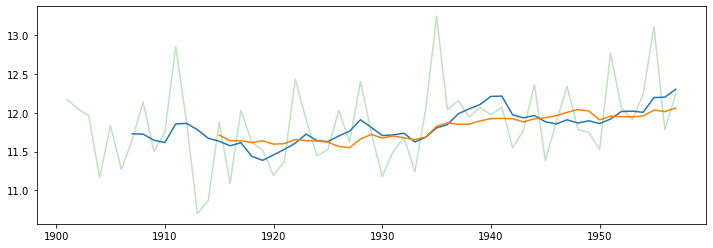

In [10]:
plt.figure(figsize=(12,4))
plt.plot(train['AverageTemperature'].rolling(7).mean())
plt.plot(train['AverageTemperature'].rolling(15).mean())
plt.plot(train['AverageTemperature'], alpha=.3)

## Modeling

### Last observed value

In [11]:
temps = round(train['AverageTemperature'][-1:][0], 2)
yhat_df = pd.DataFrame({'AverageTemperatureLOV': [temps]}, 
                      index = validate.index)
yhat_df.head()

,AverageTemperatureLOV
dt,
1957-12-31,12.24
1958-12-31,12.24
1959-12-31,12.24
1960-12-31,12.24
1961-12-31,12.24


### Simple average

In [12]:
temps = round(train['AverageTemperature'].mean(),2)
yhat_df['AverageTemperatureSimple'] = temps
yhat_df.head()

,AverageTemperatureLOV,AverageTemperatureSimple
dt,,
1957-12-31,12.24,11.85
1958-12-31,12.24,11.85
1959-12-31,12.24,11.85
1960-12-31,12.24,11.85
1961-12-31,12.24,11.85


### Rolling average

In [13]:
temps = round(train['AverageTemperature'].rolling(5).mean()[-1], 2)
yhat_df['AverageTemperatureRolling'] = temps
yhat_df.head()

,AverageTemperatureLOV,AverageTemperatureSimple,AverageTemperatureRolling
dt,,,
1957-12-31,12.24,11.85,12.26
1958-12-31,12.24,11.85,12.26
1959-12-31,12.24,11.85,12.26
1960-12-31,12.24,11.85,12.26
1961-12-31,12.24,11.85,12.26


### Holt's linear trend

In [14]:
model = Holt(train['AverageTemperature'], exponential=False, damped=True)
model = model.fit(optimized=True)
temps = model.predict(start = validate.AverageTemperature.index[0],
                           end = validate.AverageTemperature.index[-1])
yhat_df['AverageTemperatureHolt'] = round(temps, 2)

In [15]:
yhat_df.head()

,AverageTemperatureLOV,AverageTemperatureSimple,AverageTemperatureRolling,AverageTemperatureHolt
dt,,,,
1957-12-31,12.24,11.85,12.26,12.08
1958-12-31,12.24,11.85,12.26,12.08
1959-12-31,12.24,11.85,12.26,12.09
1960-12-31,12.24,11.85,12.26,12.09
1961-12-31,12.24,11.85,12.26,12.09


## Evaluate

In [16]:
results = pd.DataFrame()
for col in yhat_df.columns:
    results[col] = [round(sqrt(mean_squared_error(validate['AverageTemperature'], yhat_df[col])), 4)]
results

## Test

In [18]:
tralidate = df[: validate_end_index]

In [19]:
tralidate

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1900-12-31,12.172417,0.433083
1901-12-31,12.051583,0.447167
1902-12-31,11.963167,0.466833
1903-12-31,11.166833,0.509250
1904-12-31,11.833250,0.478583
...,...,...
1986-12-31,12.352167,0.222167
1987-12-31,11.453750,0.175417
1988-12-31,11.823167,0.174750


In [20]:
# Rolling average was my most successful model so I'm gonna go ahead with that.

temps = round(tralidate['AverageTemperature'].rolling(5).mean()[-1], 2)
yhat_test = pd.DataFrame({'AverageTemperatureRolling': [temps]}, 
                      index = test.index)

In [21]:
round(sqrt(mean_squared_error(test['AverageTemperature'], yhat_test['AverageTemperatureRolling'])), 4)

0.7944

# Store Item Modeling

## Acquire

In [22]:
df = acquire.complete_data(cached = True)

## Prep

In [23]:
df = prepare.prepare_items(df)
df = df[df['store_id'] == 9]
df = pd.DataFrame(df.groupby('sale_date').sales_total.sum())
df = df.resample('M').sum()

## Split

In [24]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index]
test = df[test_start_index:]

## Explore

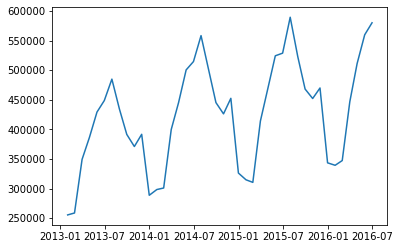

In [27]:
plt.plot(train.index, train.sales_total)

## Model

### Last observed value

In [34]:
# second to last value is being used as the last value is certainly an outlier

moneys = round(train.sales_total[-1:][0], 2)
yhat_df = pd.DataFrame({'total_sales_LOV': [moneys]}, 
                      index = test.index)
yhat_df.head()

,total_sales_LOV
sale_date,
2016-07-31 00:00:00+00:00,580322.55
2016-08-31 00:00:00+00:00,580322.55
2016-09-30 00:00:00+00:00,580322.55
2016-10-31 00:00:00+00:00,580322.55
2016-11-30 00:00:00+00:00,580322.55


### Simple average

In [35]:
moneys = round(train.sales_total.mean(), 2)
yhat_df['AverageSalesSimple'] = moneys
yhat_df.head()

,total_sales_LOV,AverageSalesSimple
sale_date,,
2016-07-31 00:00:00+00:00,580322.55,425170.64
2016-08-31 00:00:00+00:00,580322.55,425170.64
2016-09-30 00:00:00+00:00,580322.55,425170.64
2016-10-31 00:00:00+00:00,580322.55,425170.64
2016-11-30 00:00:00+00:00,580322.55,425170.64


### Rolling average

In [36]:
moneys = round(train.sales_total.rolling(5).mean()[-1], 2)
yhat_df['AverageSalesRolling'] = moneys
yhat_df.head()

,total_sales_LOV,AverageSalesSimple,AverageSalesRolling
sale_date,,,
2016-07-31 00:00:00+00:00,580322.55,425170.64,489233.2
2016-08-31 00:00:00+00:00,580322.55,425170.64,489233.2
2016-09-30 00:00:00+00:00,580322.55,425170.64,489233.2
2016-10-31 00:00:00+00:00,580322.55,425170.64,489233.2
2016-11-30 00:00:00+00:00,580322.55,425170.64,489233.2


### Holt's linear trend

In [40]:
model = Holt(train['sales_total'], exponential=False, damped=True)
model = model.fit(optimized=True)
moneys = model.predict(start = test.sales_total.index[0],
                           end = test.sales_total.index[-1])
yhat_df['AverageSalesHolt'] = round(moneys, 2)
yhat_df.head()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,total_sales_LOV,AverageSalesSimple,AverageSalesRolling,AverageSalesHolt
sale_date,,,,
2016-07-31 00:00:00+00:00,580322.55,425170.64,489233.2,582357.94
2016-08-31 00:00:00+00:00,580322.55,425170.64,489233.2,584463.88
2016-09-30 00:00:00+00:00,580322.55,425170.64,489233.2,586548.76
2016-10-31 00:00:00+00:00,580322.55,425170.64,489233.2,588612.79
2016-11-30 00:00:00+00:00,580322.55,425170.64,489233.2,590656.17


## Evaluate

In [42]:
results = pd.DataFrame()
for col in yhat_df.columns:
    results[col] = [round(sqrt(mean_squared_error(test['sales_total'], yhat_df[col])), 4)]
results

,total_sales_LOV,AverageSalesSimple,AverageSalesRolling,AverageSalesHolt
0,115023.578,123554.5686,92681.8829,127888.7386


## Predict

In [64]:
final = pd.DataFrame()
final['sale_date'] = test.shift(periods=12, freq='M').index[6:]
final = final.set_index('sale_date')
final['store_id'] = 9
moneys = round(test.sales_total.rolling(5).mean()[-1], 2)
final['y_hat_pred'] = moneys

In [65]:
final

,store_id,y_hat_pred
sale_date,,
2018-01-31 00:00:00+00:00,9,508498.98
2018-02-28 00:00:00+00:00,9,508498.98
2018-03-31 00:00:00+00:00,9,508498.98
2018-04-30 00:00:00+00:00,9,508498.98
2018-05-31 00:00:00+00:00,9,508498.98
2018-06-30 00:00:00+00:00,9,508498.98
2018-07-31 00:00:00+00:00,9,508498.98
2018-08-31 00:00:00+00:00,9,508498.98
2018-09-30 00:00:00+00:00,9,508498.98
